In [56]:
import pandas as pd
import numpy as np
import yfinance as yf
from scipy.spatial.distance import pdist, squareform


In [44]:
# List of Nifty 50 symbols
nifty_50_symbols = [
    "ADANIENT.NS", "ADANIPORTS.NS", "APOLLOHOSP.NS", "ASIANPAINT.NS", "AXISBANK.NS",
    "BAJAJ-AUTO.NS", "BAJFINANCE.NS", "BAJAJFINSV.NS", "BPCL.NS", "BHARTIARTL.NS",
    "BRITANNIA.NS", "CIPLA.NS", "COALINDIA.NS", "DIVISLAB.NS", "DRREDDY.NS",
    "EICHERMOT.NS", "GRASIM.NS", "HCLTECH.NS", "HDFCBANK.NS", "HDFCLIFE.NS",
    "HEROMOTOCO.NS", "HINDALCO.NS", "HINDUNILVR.NS", "ICICIBANK.NS", "INDUSINDBK.NS",
    "INFY.NS", "ITC.NS", "JSWSTEEL.NS", "KOTAKBANK.NS", "LT.NS", "M&M.NS", "MARUTI.NS",
    "NESTLEIND.NS", "NTPC.NS", "ONGC.NS", "POWERGRID.NS", "RELIANCE.NS", "SBIN.NS",
    "SUNPHARMA.NS", "TATACONSUM.NS", "TATAMOTORS.NS", "TATASTEEL.NS", "TECHM.NS",
    "TITAN.NS", "ULTRACEMCO.NS", "UPL.NS", "WIPRO.NS"

]

# Define the date range
start_date = "2020-01-01"
end_date = "2023-1-01"

# Create an empty DataFrame to store returns
returns_df = pd.DataFrame()
vol_df = pd.DataFrame()

# Fetch data and calculate returns for each symbol
for symbol in nifty_50_symbols:
    # Download historical data
    data = yf.download(symbol, start=start_date, end=end_date)
    
    # Calculate daily returns
    returns = data['Close'].pct_change().dropna()
    vol = data['Volume']
    # Add returns to the DataFrame
    returns_df[symbol] = returns
    vol_df[symbol] = vol

# Set the index name
returns_df.index.name = "Date"
vol_df.index.name = "Date"

# Display the first few rows of the DataFrame
print(returns_df.head())

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

            ADANIENT.NS  ADANIPORTS.NS  APOLLOHOSP.NS  ASIANPAINT.NS  \
Date                                                                   
2020-01-02     0.016117       0.014564       0.047885      -0.001422   
2020-01-03    -0.013731      -0.001696      -0.005720      -0.021919   
2020-01-06    -0.042007      -0.006013      -0.015881      -0.025265   
2020-01-07     0.022551       0.012099       0.011077       0.010104   
2020-01-08    -0.012497       0.002209      -0.003415       0.002552   

            AXISBANK.NS  BAJAJ-AUTO.NS  BAJFINANCE.NS  BAJAJFINSV.NS  \
Date                                                                   
2020-01-02     0.011019      -0.009238       0.003486       0.013558   
2020-01-03    -0.018495      -0.015684      -0.012388      -0.016806   
2020-01-06    -0.026516      -0.011198      -0.046918      -0.032437   
2020-01-07     0.003457       0.000099       0.002740       0.005856   
2020-01-08    -0.001722       0.007011       0.010555       0.0

In [45]:
from sklearn.metrics import pairwise_distances
import itertools

# write a function to select pairs
# function takes as input an array of formation returns and the desired number of pairs
# obs: form_ret column names are inherited original ret object
def get_pairs(form_ret, n_pairs):
    # replace first return with 0 so cum returns start at 1
    form_ret.iloc[0, :] = 0

    # create object with cumulative returns
    prc = (form_ret + 1.).cumprod()

    # define number of stocks and total number of pairs
    num_stocks = prc.shape[1]
    total_pairs = int(prc.shape[1] * (prc.shape[1] - 1) / 2)

    # create column with pair combinations to calculate distances
    pairs = np.asarray(list(itertools.permutations(prc.columns, 2)))

    # keep only one set of combinations
    pairs = pd.DataFrame(pairs[pairs[:, 1] > pairs[:, 0]], columns=["leg_1", "leg_2"])

    # calculate distances between normalized prices
    pairs_dist = pairwise_distances(prc.transpose(), prc.transpose())
    pairs_dist = pd.Series(pairs_dist[np.triu_indices(num_stocks, k=1)])
    pairs["dist"] = pairs_dist

    # remove pairs with 0 distance if any
    pairs = pairs[pairs.dist > 0]

    # order according to distance and select pairs
    pairs = pairs.sort_values("dist", ascending=True)
    pairs = pairs.loc[pairs.index[0:min(n_pairs, pairs.shape[0])]]

    # for these pairs, store the standard deviation of the spread
    pairs["spread_std"] = np.std(np.asarray(prc.loc[:, pairs.leg_1]) - np.asarray(prc.loc[:, pairs.leg_2]), axis=0,
                                 ddof=1)
    pairs.index = np.arange(pairs.shape[0])
    
    # returns selected pairs
    return pairs


In [46]:
# test the function for a specific date
n_pairs = 15

# formation period total return including dividends
form_ret = returns_df.loc["2020-01-01":"2020-12-31"].copy()

# daily volumes for formation period
form_vol = vol_df["2020-01-01":"2020-12-31"].copy()
form_vol[form_vol.isna()] = 0

# boolean to identify eligible stocks
#ava_stocks = (form_ret.isna().sum() == 0) & ((form_vol == 0).sum() == 0)

# create matrices with formation and trading prices only for selected stocks
#form_ret = ret.loc["1962-01-01":"1962-12-31",  ava_stocks]
#trade_ret = ret.loc["1963-01-01":"1963-06-30", ava_stocks]
trade_ret = returns_df.loc["2021-01-01":"2021-06-30"]

pairs = get_pairs(form_ret, n_pairs = 15)
pairs


,leg_1,leg_2,dist,spread_std
0,ICICIBANK.NS,LT.NS,0.684405,0.043015
1,AXISBANK.NS,SBIN.NS,0.726851,0.039851
2,HINDUNILVR.NS,NESTLEIND.NS,0.823585,0.052053
3,HDFCBANK.NS,KOTAKBANK.NS,0.868417,0.054964
4,ITC.NS,NTPC.NS,0.957247,0.059539
5,HCLTECH.NS,INFY.NS,0.961087,0.047572
6,TITAN.NS,ULTRACEMCO.NS,0.963837,0.060431
7,BPCL.NS,JSWSTEEL.NS,0.985568,0.227732
8,HDFCBANK.NS,MARUTI.NS,1.027090,0.065089
9,COALINDIA.NS,ONGC.NS,1.033744,0.055064


In [47]:
# function to calculate returns on a set of pairs over a given trading period
def calculate_pairs_returns(trade_ret, pairs, d_open=2, wait1d=1):
    # trade_ret : array of returns over trading period
    # pairs  : data frame with information about pairs
    # d_open : number of standard deviations to open a pair
    # wait1d : number of days to wait before opening trade, default = 1

    # don't need dates as indices; switch to integers
    trade_ret_dates = trade_ret.index
    trade_ret.index = np.arange(trade_ret.shape[0])
    trade_ret.iloc[0, :] = 0

    # to treat delisting correctly, identify last non NA values
    last_valid_ret_ind = trade_ret.apply(pd.Series.last_valid_index)

    # can safely replace NAs with 0 before this index.
    for idx, column in enumerate(trade_ret.columns):
        r = trade_ret.loc[trade_ret.index[0]:last_valid_ret_ind.iloc[idx], column]
        r = r.fillna(0)
        trade_ret.loc[trade_ret.index[0]:last_valid_ret_ind.iloc[idx], column] = r

    # "normalize" trading period prices to start at 1
    trade_prc = (trade_ret + 1.).cumprod()

    # total number of days in trading period
    trading_days = trade_prc.shape[0]

    # total number of pairs considered
    num_pairs = pairs.shape[0]

    # storage for intermediate calculations
    directions = pd.DataFrame(np.zeros((trading_days, num_pairs)))
    payoffs = pd.DataFrame(np.zeros((trading_days, num_pairs)))
    
    # loop through pairs and check for trades
    for idx_pair, pair in pairs.iterrows():

        # create df to store weights (the w1 and w2 in GGR) and returns of legs
        pair_calcs = pd.DataFrame(np.zeros((trading_days, 9)),
                                  columns=["p_1", "p_2", "s", "direction", "w_1", "w_2", "r_1", "r_2", "payoff"])

        # identify pair legs, build prices, returns and spread vectors
        leg_1 = pair.leg_1
        leg_2 = pair.leg_2
        pair_calcs.p_1 = trade_prc.loc[:, leg_1]
        pair_calcs.p_2 = trade_prc.loc[:, leg_2]
        pair_calcs.r_1 = trade_ret.loc[:, leg_1]
        pair_calcs.r_2 = trade_ret.loc[:, leg_2]
        last_day = max(pair_calcs.p_1.last_valid_index(), pair_calcs.p_2.last_valid_index())
        pair_calcs.r_1 = pair_calcs.r_1.fillna(0)
        pair_calcs.r_2 = pair_calcs.r_2.fillna(0)

        pair_calcs.s = (pair_calcs.p_1 - pair_calcs.p_2) / pair.spread_std

        open_ids = np.array(trade_ret.index * (np.abs(pair_calcs.s) > d_open))
        open_ids = open_ids[open_ids != 0]
        open_ids = open_ids[open_ids <= last_day]

        close_ids = np.array(trade_ret.index[np.sign(pair_calcs.s).diff() != 0])
        close_ids = close_ids[~np.isnan(close_ids)]
        close_ids = np.append(close_ids, last_day)

        # date when first trade opens
        if len(open_ids) != 0:
            t_open = open_ids[0]
        else:
            t_open = np.nan

        # if there has been a divergence in the trading period
        if ~np.isnan(t_open):
            while ~np.isnan(t_open) & (t_open < last_day - wait1d):
                # check when trade closed
                t_close = np.min(close_ids[close_ids > t_open + wait1d])

                # store direction of trade over period when trade is open
                pair_calcs.loc[(t_open + wait1d + 1): (t_close + 1), "direction"] = -np.sign(
                    pair_calcs.loc[t_open - wait1d, "s"])

                # update w1 and w2
                pair_calcs.w_1[(t_open + wait1d):(t_close + 1)] = np.append(1., (
                        1 + pair_calcs.r_1[(t_open + wait1d): (t_close)]).cumprod())
                pair_calcs.w_2[(t_open + wait1d):(t_close + 1)] = np.append(1., (
                        1 + pair_calcs.r_2[(t_open + wait1d): (t_close)]).cumprod())

                # update t_open => moves to next trade for this pair
                if any(open_ids > t_close):
                    t_open = open_ids[open_ids > t_close][0]
                else:
                    t_open = np.nan

        # calculate and store the payoffs for this pair
        pair_calcs["payoffs"] = pair_calcs.direction * (
                pair_calcs.w_1 * pair_calcs.r_1 - pair_calcs.w_2 * pair_calcs.r_2)
        payoffs.loc[:, idx_pair] = pair_calcs["payoffs"]
        directions.loc[:, idx_pair] = pair_calcs["direction"]

    directions.index = trade_ret_dates
    payoffs.index = trade_ret_dates

    # returns for committed capital approach - just the column average of payoffs
    returns_cc = payoffs.mean(axis=1)

    # for fully-invested approach, capital is divided among open pairs

    num_open_pairs = (directions != 0).sum(axis=1)
    num_open_pairs[num_open_pairs > 0] = 1. / num_open_pairs
    weights_fi = pd.concat([num_open_pairs] * num_pairs, axis=1)
    returns_fi = (weights_fi * payoffs).sum(axis=1)

    # return everything as a dictionary
    return {"pairs": pairs, "directions": directions, "payoffs": payoffs, "returns_cc": returns_cc,
            "returns_fi": returns_fi}


In [48]:
# use first pair in this example
i_pair = 0

rets_pair_form = form_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]


In [49]:
rets_pair_form.iloc[0,:] = 0
rets_pair_form.head()

,ICICIBANK.NS,LT.NS
Date,,
2020-01-02,0.000000,0.000000
2020-01-03,-0.003237,-0.007619
2020-01-06,-0.024403,-0.013707
2020-01-07,-0.005326,0.002848
2020-01-08,0.005833,-0.021923


In [50]:
# normalized prices and std spread in formation period
norm_prices_form = (1+rets_pair_form).cumprod()
norm_prices_form["std_spread"] = (norm_prices_form[pairs.leg_1[i_pair]] - norm_prices_form[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]


In [51]:
norm_prices_form.head()

,ICICIBANK.NS,LT.NS,std_spread
Date,,,
2020-01-02,1.000000,1.000000,0.000000
2020-01-03,0.996763,0.992381,0.101872
2020-01-06,0.972438,0.978778,-0.147377
2020-01-07,0.967259,0.981565,-0.332591
2020-01-08,0.972901,0.960046,0.298836


In [52]:
# normalized prices and std spread in trading period
rets_pair_trade = trade_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]
rets_pair_trade.iloc[0,:] = 0
norm_prices_trade = (1+rets_pair_trade).cumprod()
norm_prices_trade["std_spread"] = (norm_prices_trade[pairs.leg_1[i_pair]] - norm_prices_trade[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]

norm_prices_trade.head()

,ICICIBANK.NS,LT.NS,std_spread
Date,,,
2021-01-01,1.000000,1.000000,0.000000
2021-01-04,1.007962,1.013570,-0.130362
2021-01-05,1.018483,1.007170,0.263000
2021-01-06,1.036398,1.013107,0.541456
2021-01-07,1.025782,1.032344,-0.152547


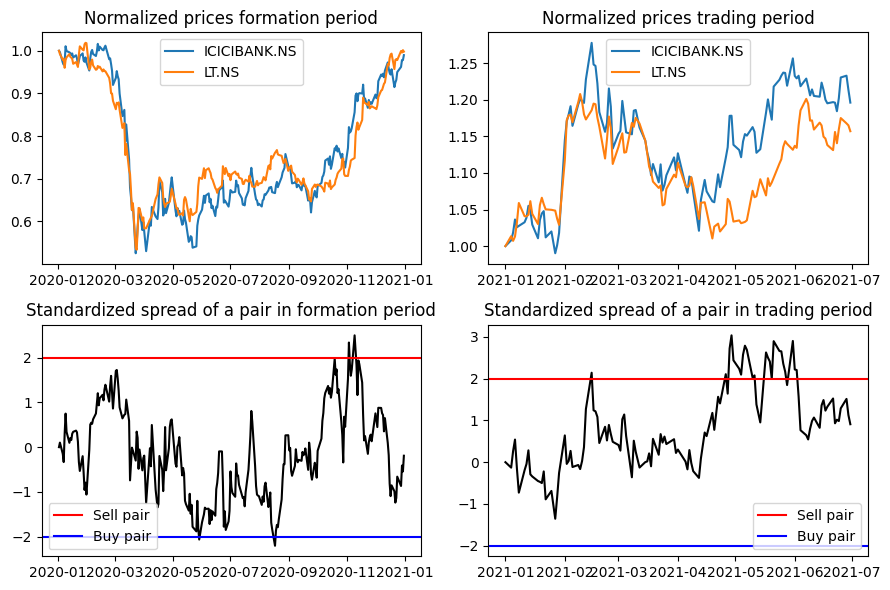

In [53]:
import matplotlib.pyplot as plt

# ploting: left = formation period, right = trading period

# plot normalized prices and std spread in trading period
fig = plt.figure();
fig.set_size_inches(9, 6);
ax1 = fig.add_subplot(2,2,1);
ax1.plot(norm_prices_form[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax1.legend();
ax1.set_title("Normalized prices formation period");

ax2 = fig.add_subplot(2,2,3);
ax2.plot(norm_prices_form["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax2.legend();
ax2.set_title("Standardized spread of a pair in formation period");
fig.tight_layout();

ax3 = fig.add_subplot(2,2,2);
ax3.plot(norm_prices_trade[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax3.legend();
ax3.set_title("Normalized prices trading period");

ax3 = fig.add_subplot(2,2,4);
ax3.plot(norm_prices_trade["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax3.legend();
ax3.set_title("Standardized spread of a pair in trading period");
fig.tight_layout();

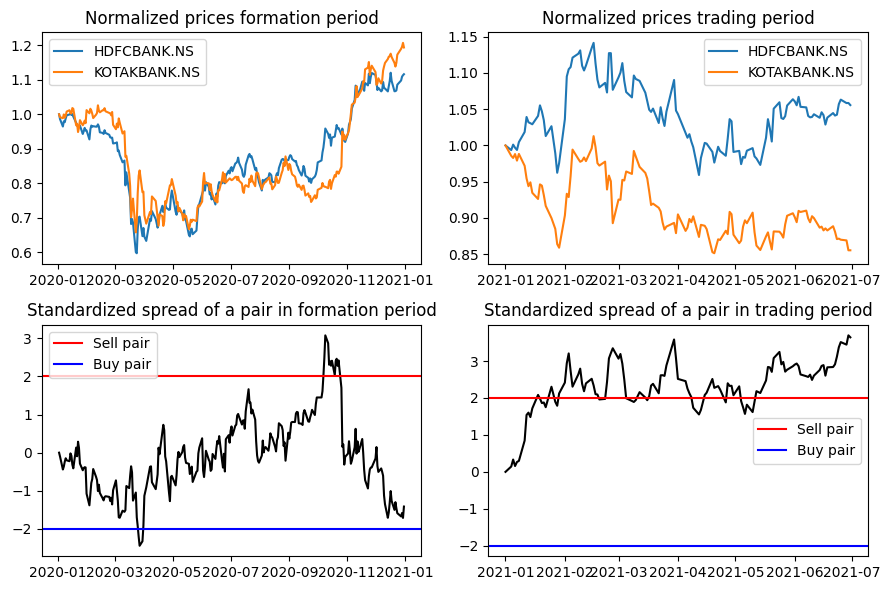

In [54]:
# inspecting another pair
i_pair = 3

rets_pair_form = form_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]
rets_pair_form.iloc[0,:] = 0

# normalized prices and std spread in formation period
norm_prices_form = (1+rets_pair_form).cumprod()
norm_prices_form["std_spread"] = (norm_prices_form[pairs.leg_1[i_pair]] - norm_prices_form[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]

# normalized prices and std spread in trading period
rets_pair_trade = trade_ret.loc[:, [pairs.leg_1[i_pair],pairs.leg_2[i_pair]] ]
rets_pair_trade.iloc[0,:] = 0
norm_prices_trade = (1+rets_pair_trade).cumprod()
norm_prices_trade["std_spread"] = (norm_prices_trade[pairs.leg_1[i_pair]] - norm_prices_trade[pairs.leg_2[i_pair]] )/pairs.spread_std[i_pair]


# ploting: left = formation period, right = trading period

# plot normalized prices and std spread in trading period
fig = plt.figure();
fig.set_size_inches(9, 6);
ax1 = fig.add_subplot(2,2,1);
ax1.plot(norm_prices_form[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax1.legend();
ax1.set_title("Normalized prices formation period");

ax2 = fig.add_subplot(2,2,3);
ax2.plot(norm_prices_form["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax2.legend();
ax2.set_title("Standardized spread of a pair in formation period");
fig.tight_layout();

ax3 = fig.add_subplot(2,2,2);
ax3.plot(norm_prices_trade[[pairs.leg_1[i_pair], pairs.leg_2[i_pair]]], label = [pairs.leg_1[i_pair], pairs.leg_2[i_pair]]);
ax3.legend();
ax3.set_title("Normalized prices trading period");

ax3 = fig.add_subplot(2,2,4);
ax3.plot(norm_prices_trade["std_spread"], color = "black");
plt.axhline(y=2, color='r', linestyle='-', label = "Sell pair");
plt.axhline(y=-2, color='b', linestyle='-', label = "Buy pair");
ax3.legend();
ax3.set_title("Standardized spread of a pair in trading period");
fig.tight_layout();



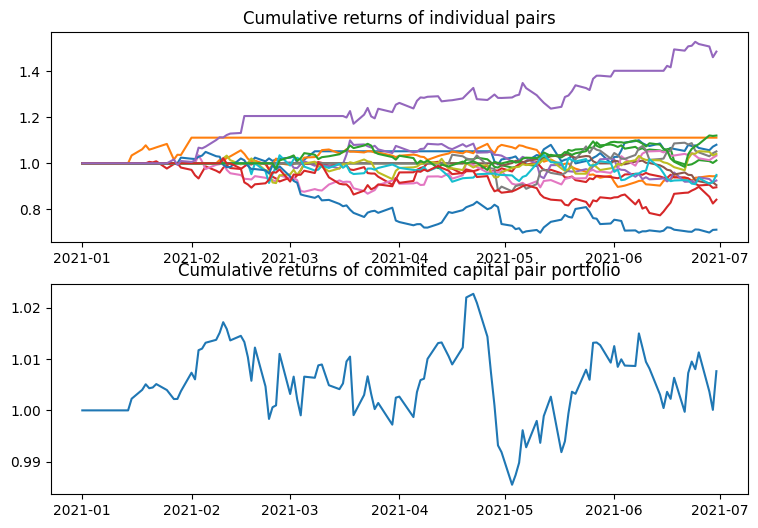

In [55]:
trades = calculate_pairs_returns(trade_ret.copy(), pairs = pairs, d_open = 2, wait1d = 1)
# returns of all pair trades 
pair_rets = trades["payoffs"]

fig = plt.figure();
fig.set_size_inches(9, 6);
ax1 = fig.add_subplot(2,1,1);
ax1.plot((1+pair_rets).cumprod());
ax1.set_title("Cumulative returns of individual pairs");
ax2 = fig.add_subplot(2,1,2);
ax2.plot((1+trades["returns_cc"]).cumprod());
ax2.set_title("Cumulative returns of commited capital pair portfolio");
